# XGBoost para Previsão Multivariada (Soma das Próximas 4 Semanas)
Este notebook demonstra o treinamento e avaliação de um regressor XGBoost para prever a soma das próximas 4 semanas (previsão mensal) das taxas de morbidade respiratória em um município brasileiro selecionado, usando todas as features disponíveis.

In [3]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"Project root: {project_root}")

# Add the project root to sys.path (not the src directory)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to sys.path")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from src.preprocessing import load_city_data, filter_city, clean_timeseries, prepare_data_for_model
from src.utils import plot_forecast, plot_forecast_error
import warnings
warnings.filterwarnings('ignore')

Project root: c:\Users\pedro\OneDrive - Unesp\Documentos\GitHub\cities-models\cities-models


## Carregamento e Seleção da Cidade

In [5]:
# Caminho dos dados
csv_path = '../data/df_base_morb_resp.csv'
df = load_city_data(csv_path)

# Selecione a cidade (por código IBGE)
CD_MUN_SELECTED = 3550308  # Campinas (altere conforme necessário)
df_city = filter_city(df, cd_mun=CD_MUN_SELECTED)
df_city = clean_timeseries(df_city, target_column='target')
print(f"Selected city shape: {df_city.shape}")

Selected city shape: (1200, 11)


## Pré-processamento
Prepare os dados para o XGBoost. Use todas as features exceto 'CD_MUN' e 'week'. O alvo é a soma das próximas 4 semanas ('target').

In [6]:
model_params = {
    'sequence_length': 12,  # Use 8 semanas de histórico
    'forecast_horizon': 4, # Soma das próximas 4 semanas
    'normalization': None, # Sem normalização para XGBoost
    'val_size': None
}
target_column = 'target'

data_dict = prepare_data_for_model(
    df=df_city,
    target_column=target_column,
    sequence_length=model_params['sequence_length'],
    forecast_horizon=model_params['forecast_horizon'],
    normalization=model_params['normalization'],
    val_size=model_params.get('val_size', None)
)

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict.get('X_val', None)
y_val = data_dict.get('y_val', None)
X_test = data_dict['X_test']
y_test = data_dict['y_test']
test_df = data_dict['test_df']
feature_columns = data_dict.get('feature_columns', None)

# Flatten input for XGBoost
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [12]:
X_train = X_train.reshape(X_train.shape[0], -1)
if X_val is not None:
    X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [13]:
# --- Hyperparameter Tuning for XGBoost (Time Series Holdout) ---
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_error
import joblib

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5]
}

n_iter = 100
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
best_mae = float('inf')
best_model = None
best_params = None

for i, params in enumerate(param_list):
    xgb = XGBRegressor(random_state=42, **params)
    xgb.fit(X_train, y_train)
    if X_val is not None and y_val is not None:
        y_val_pred = xgb.predict(X_val)
        val_mae = mean_absolute_error(y_val, y_val_pred)
    else:
        y_val_pred = xgb.predict(X_test)
        val_mae = mean_absolute_error(y_test, y_val_pred)
    if val_mae < best_mae:
        best_mae = val_mae
        best_model = xgb
        best_params = params
    if (i+1) % 10 == 0:
        print(f"Iteration {i+1}/{n_iter} - Current Best MAE: {best_mae:.4f}")

print("Best hyperparameters:", best_params)
print("Best validation MAE:", best_mae)

# Save the best model
os.makedirs('results/xgboost_timeseries', exist_ok=True)
joblib.dump(best_model, 'results/xgboost_timeseries/best_xgb_model.joblib')

# Use the best model for test predictions
y_pred = best_model.predict(X_test)

Iteration 10/100 - Current Best MAE: 215.8963
Iteration 20/100 - Current Best MAE: 129.4093
Iteration 20/100 - Current Best MAE: 129.4093
Iteration 30/100 - Current Best MAE: 129.4093
Iteration 30/100 - Current Best MAE: 129.4093
Iteration 40/100 - Current Best MAE: 125.7963
Iteration 40/100 - Current Best MAE: 125.7963
Iteration 50/100 - Current Best MAE: 125.7963
Iteration 50/100 - Current Best MAE: 125.7963
Iteration 60/100 - Current Best MAE: 109.9665
Iteration 60/100 - Current Best MAE: 109.9665
Iteration 70/100 - Current Best MAE: 109.9665
Iteration 70/100 - Current Best MAE: 109.9665
Iteration 80/100 - Current Best MAE: 109.9665
Iteration 80/100 - Current Best MAE: 109.9665
Iteration 90/100 - Current Best MAE: 109.9665
Iteration 90/100 - Current Best MAE: 109.9665
Iteration 100/100 - Current Best MAE: 109.9665
Best hyperparameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}
Best valid

## Treinamento do Modelo XGBoost

In [7]:
xgb = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

## Avaliação do Modelo

In [ ]:
y_pred_1d = reduce_to_1d(y_pred)

def reduce_to_1d(arr):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return arr
    if arr.ndim == 2:
        if arr.shape[1] == 1:
            return arr.ravel()
        else:
            return arr.sum(axis=1)
    raise ValueError(f"Unexpected array shape: {arr.shape}")

# Garantir arrays 1D para métricas e visualização
y_test_1d = reduce_to_1d(y_test)

mae = mean_absolute_error(y_test_1d, y_pred_1d)
rmse = np.sqrt(mean_squared_error(y_test_1d, y_pred_1d))
r2 = r2_score(y_test_1d, y_pred_1d)
print(f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.3f}")

MAE: 215.39
RMSE: 294.95
R²: -6.977


## Visualização: Previsão vs Real e Erros

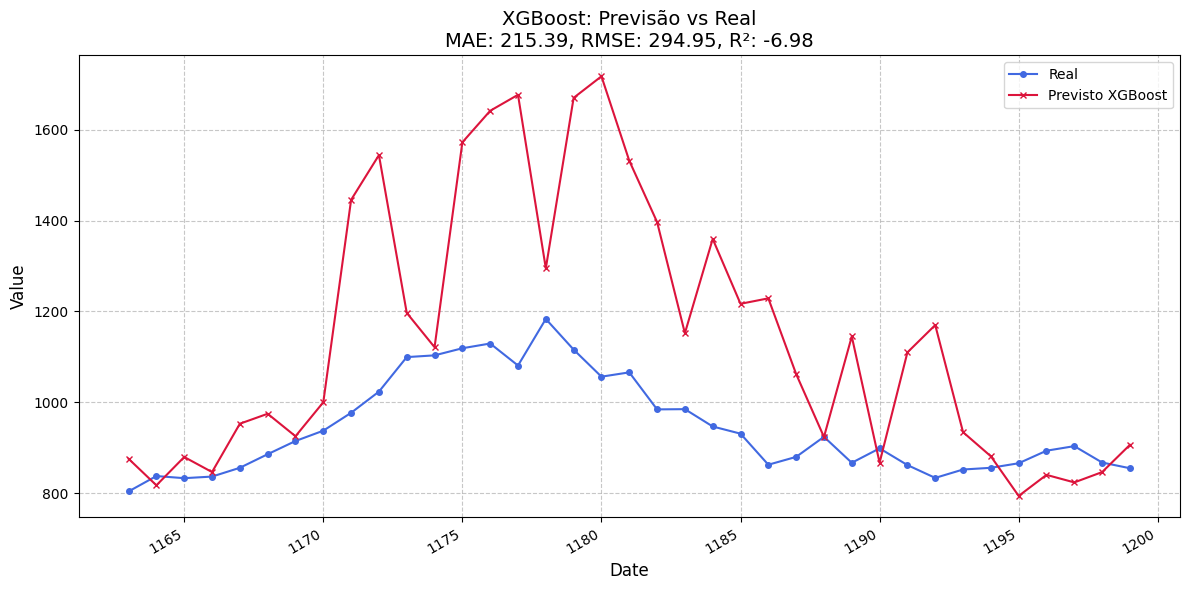

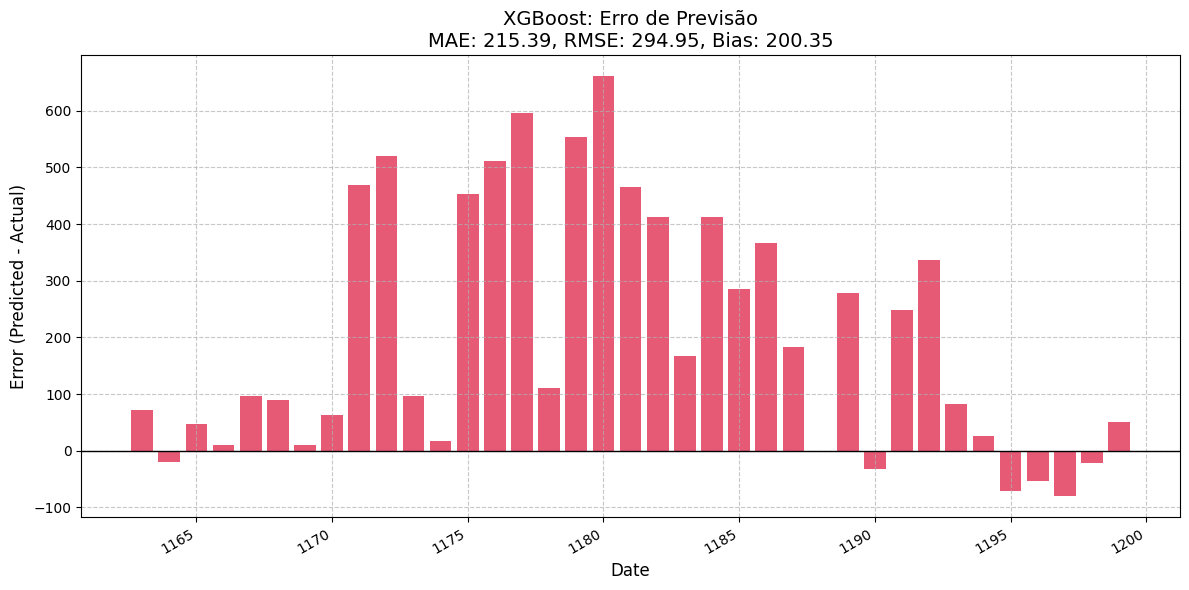

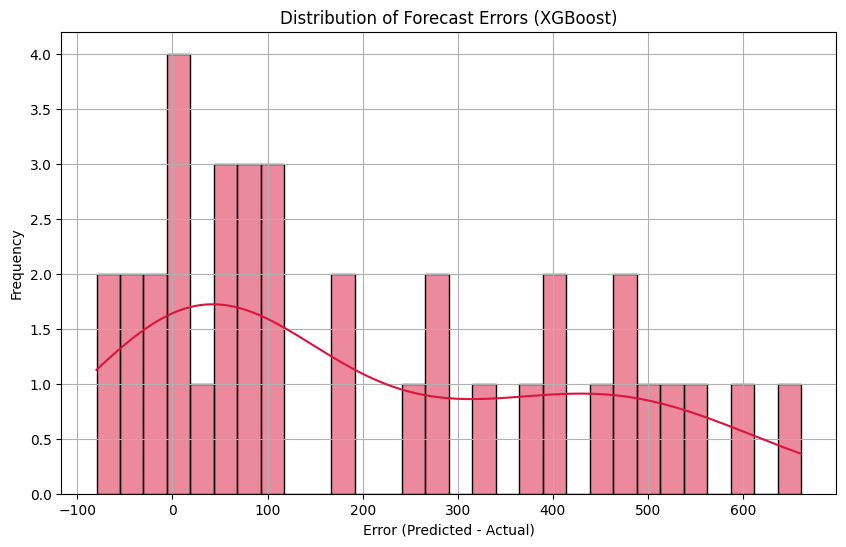

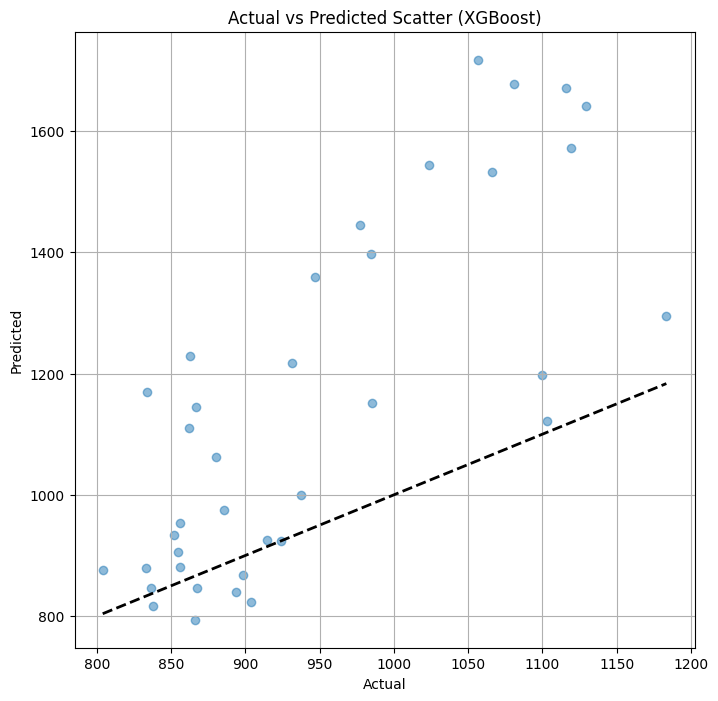

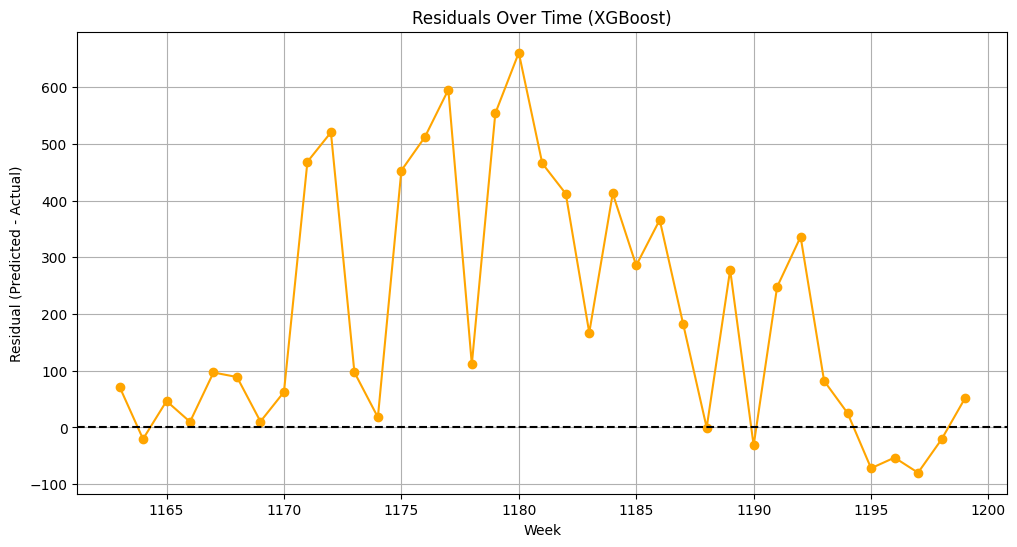

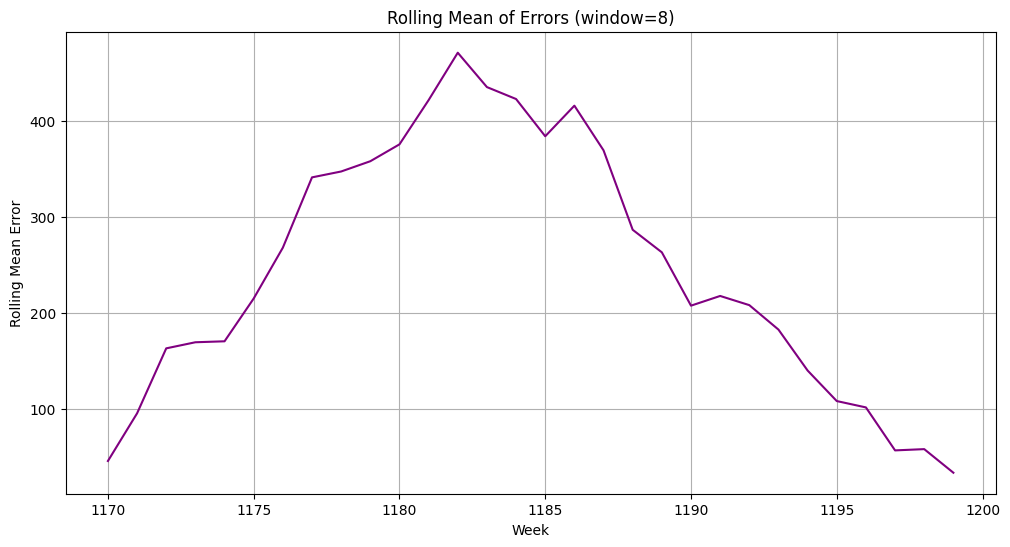

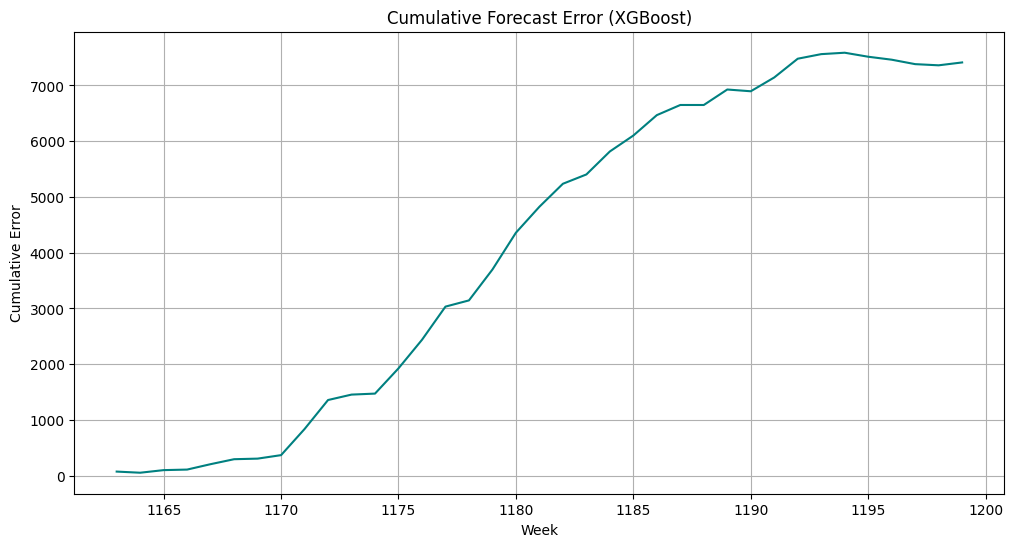

In [9]:
# Eixo temporal
if 'week' in test_df.columns:
    test_dates = test_df['week'].values[-len(y_test_1d):]
else:
    test_dates = np.arange(len(y_test_1d))

# 1. Forecast vs Actual
fig1 = plot_forecast(
    true_values=y_test_1d,
    predictions=y_pred_1d,
    dates=test_dates,
    title="XGBoost: Previsão vs Real",
    true_label="Real",
    pred_label="Previsto XGBoost"
)
plt.show()

# 2. Forecast Error
fig2 = plot_forecast_error(
    true_values=y_test_1d,
    predictions=y_pred_1d,
    dates=test_dates,
    title="XGBoost: Erro de Previsão"
)
plt.show()

# 3. Distribution of Errors
erros = y_pred_1d - y_test_1d
plt.figure(figsize=(10,6))
sns.histplot(erros, kde=True, bins=30, color='crimson')
plt.title('Distribution of Forecast Errors (XGBoost)')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8,8))
plt.scatter(y_test_1d, y_pred_1d, alpha=0.5)
plt.plot([y_test_1d.min(), y_test_1d.max()], [y_test_1d.min(), y_test_1d.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Scatter (XGBoost)')
plt.grid(True)
plt.show()

# 5. Residuals Over Time
plt.figure(figsize=(12,6))
plt.plot(test_dates, erros, marker='o', linestyle='-', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time (XGBoost)')
plt.xlabel('Week')
plt.ylabel('Residual (Predicted - Actual)')
plt.grid(True)
plt.show()

# 6. Rolling Mean of Errors
window = 8
rolling_error = pd.Series(erros).rolling(window=window).mean()
plt.figure(figsize=(12,6))
plt.plot(test_dates, rolling_error, color='purple')
plt.title(f'Rolling Mean of Errors (window={window})')
plt.xlabel('Week')
plt.ylabel('Rolling Mean Error')
plt.grid(True)
plt.show()

# 7. Cumulative Error
cumulative_error = np.cumsum(erros)
plt.figure(figsize=(12,6))
plt.plot(test_dates, cumulative_error, color='teal')
plt.title('Cumulative Forecast Error (XGBoost)')
plt.xlabel('Week')
plt.ylabel('Cumulative Error')
plt.grid(True)
plt.show()

## Importância das Features

In [ ]:
importances = xgb.feature_importances_
if feature_columns is not None:
    n_lags = X_train.shape[1] // len(feature_columns)
    feature_names = [f"{col}_t-{lag}" for lag in range(model_params['sequence_length'], 0, -1) for col in feature_columns]
else:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(12,6))
feat_imp.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.ylabel('Importance')
plt.grid(True)
plt.show()

## Salvar Previsões e Métricas

In [ ]:
from src.train import save_predictions, save_metrics
# Salvar previsões
preds_file = save_predictions(
    y_true=y_test_1d,
    y_pred=y_pred_1d,
    dates=test_dates,
    city_name='Campinas',
    model_name='xgboost',
    output_dir='results/xgboost_timeseries'
)
print(f"Previsões salvas em: {preds_file}")

# Salvar métricas
metrics = {'mae': mae, 'rmse': rmse, 'r2': r2}
metrics_file = save_metrics(
    metrics=metrics,
    city_name='Campinas',
    model_name='xgboost',
    output_dir='results/xgboost_timeseries',
    params=model_params
)
print(f"Métricas salvas em: {metrics_file}")

## Conclusão
O XGBoost multivariado permite prever a soma das próximas 4 semanas usando todas as features disponíveis. Compare seu desempenho com os modelos neurais e baselines nos outros notebooks.